# Part 1

In [3]:
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import GMM
from scipy import stats

class test_delta_gmm(GMM):
    def momcond(self, params):
        # Explicitly separate delta as last parameter for clarity
        beta = params[:-1]  # First four parameters are original coefficients
        delta = params[-1]  # Last parameter is delta
        
        # Get variables
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        # Basic error term (Y - XB)
        error = endog - beta[0] - beta[1] * exog[:,0] - beta[2] * exog[:,1] - beta[3] * exog[:,2]
        
        # Original moment conditions
        error0 = error
        error1 = error * exog[:,1]
        error2 = error * exog[:,2]
        
        # Instrument moments with delta adjustment
        # This directly implements Z'(Y - XB) = δ[1,1,1]'
        error3 = error * inst[:,0] - delta
        error4 = error * inst[:,1] - delta
        error5 = error * inst[:,2] - delta

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

# Load and prepare data
url = "https://raw.githubusercontent.com/neilaxu/schulich_data_science/main/Predictive%20Modelling/Assignment%202/midterm_partone.csv"
data = pd.read_csv(url)

# Prepare arrays
y_vals = np.array(data["Stock Change"])
x_vals = np.array(data[["Inventory Turnover", "Operating Profit", "Interaction Effect"]])
iv_vals = np.array(data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])

# Initial values including delta
beta0 = np.array([0.1, 0.1, 0.1, 0.1, 0.0])  # Last value is initial delta

# Estimate model
model = test_delta_gmm(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5)
results = model.fit(beta0)

# Print full model results
print(results.summary())

# Calculate test statistics for delta
std_errors = np.sqrt(np.diag(results.cov_params()))
delta_t_stat = results.params[-1] / std_errors[-1]
delta_p_value = 2 * (1 - stats.norm.cdf(abs(delta_t_stat)))

# Print formal test results
print("\nFormal Test of Expert's Claim:")
print("=" * 50)
print(f"H0: δ = 0 (No bias in moment conditions)")
print(f"H1: δ ≠ 0 (Expert's claim of bias is correct)")
print("-" * 50)
print(f"Estimated δ: {results.params[-1]:.6f}")
print(f"Standard Error: {std_errors[-1]:.6f}")
print(f"Z-statistic: {delta_t_stat:.4f}")
print(f"P-value: {delta_p_value:.4f}")

# Print interpretation
print("\nInterpretation:")
print("-" * 50)
if delta_p_value < 0.05:
    print("Statistical Evidence: Reject H0")
    print(f"Conclusion: Expert's claim of bias (δ ≈ {results.params[-1]:.4f}) is supported")
else:
    print("Statistical Evidence: Fail to reject H0")
    print("Conclusion: No statistical support for expert's claim of bias")

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 12
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                            test_delta_gmm Results                            
Dep. Variable:                      y   Hansen J:                       0.5862
Model:                 test_delta_gmm   Prob (Hansen J):                 0.444
Method:                           GMM                                         
D

# Mathematical Framework: Testing for Bias in GMM Moment Conditions

## 1. Original Problem Setup

The expert claims bias exists in instrumental variable moment conditions:

$Z^T(Y - XB) = \delta\begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix}$

where:
- $Y$ is the stock return (dependent variable)
- $X$ contains Inventory Turnover, Operating Profit, and Interaction Effect
- $Z$ contains Current Ratio, Quick Ratio, and Debt Asset Ratio
- $\delta$ is the claimed bias parameter

## 2. Testing Framework

### Standard GMM Moment Conditions:
- Original conditions: $E[Z^T(Y - XB)] = 0$
- Under expert's claim: $E[Z^T(Y - XB)] = \delta\mathbf{1}$

### Hypothesis Setup:
- $H_0: \delta = 0$ (No bias in moment conditions)
- $H_1: \delta \neq 0$ (Expert's claim is correct)

## 3. Implementation Approach

1. **Parameter Vector**:
   - Expanded to include δ: $\theta = [B', \delta]'$
   - $B$ contains original coefficients
   - $\delta$ is treated as additional parameter to estimate

2. **Modified Moment Conditions**:
   - $E[Y - XB] = 0$
   - $E[(Y - XB)X] = 0$
   - $E[Z^T(Y - XB) - \delta\mathbf{1}] = 0$

## 4. GMM Estimation Framework

### Objective Function
The GMM estimator minimizes:
$Q_n(\theta) = \bar{g}_n(\theta)'W_n\bar{g}_n(\theta)$

where:
- $\theta = [B', \delta]'$ is the parameter vector
- $\bar{g}_n(\theta)$ is the sample moment vector
- $W_n$ is the optimal weighting matrix

### Optimal Weighting
1. **First Stage**:
   - Use identity matrix: $W_n^{(1)} = I$
   - Get initial estimates $\hat{\theta}^{(1)}$

2. **Second Stage**:
   - Update weight: $W_n^{(2)} = [\frac{1}{n}\sum_{i=1}^n g_i(\hat{\theta}^{(1)})g_i(\hat{\theta}^{(1)})']^{-1}$
   - Obtain efficient estimates $\hat{\theta}^{(2)}$

### Asymptotic Properties

1. **Consistency**:
   $\hat{\theta} \xrightarrow{p} \theta_0$

2. **Asymptotic Normality**:
   $\sqrt{n}(\hat{\theta} - \theta_0) \xrightarrow{d} N(0, V)$

   where $V = (G'WG)^{-1}G'W\Omega WG(G'WG)^{-1}$
   - $G = E[\frac{\partial g_i(\theta_0)}{\partial \theta'}]$
   - $\Omega = E[g_i(\theta_0)g_i(\theta_0)']$

### Specification Testing

1. **Hansen J-statistic**:
   $J_n = n\bar{g}_n(\hat{\theta})'W_n\bar{g}_n(\hat{\theta}) \xrightarrow{d} \chi^2_{m-k}$
   
   where:
   - $m$ is number of moment conditions
   - $k$ is number of parameters
   - Degrees of freedom = m - k

2. **Delta Test**:
   $z_{\delta} = \frac{\hat{\delta}}{SE(\hat{\delta})} \xrightarrow{d} N(0,1)$

## 5. Technical Implementation

```python
error = Y - XB
g = [error,                    # Basic moment
     error * X,                # Exogenous variable moments
     error * Z - delta]        # IV moments with bias adjustment
```

This framework allows us to:
1. Directly estimate the bias parameter
2. Test its statistical significance
3. Evaluate the expert's claim rigorously

## 6. Interpretation

Based on test statistics:
- Z-statistic = $\frac{\hat{\delta}}{SE(\hat{\delta})}$
- P-value determines if we reject $H_0$
- Model specification via Hansen J-test

This provides a formal statistical framework for evaluating the expert's claim about bias in the moment conditions.

# Summary of Findings: Evaluating Expert's Claim of Bias in GMM

## Model Results and Test Statistics

1. **Model Quality**:
   - Hansen J statistic = 0.5862 (p = 0.444)
   - Indicates well-specified model
   - Good convergence (low function values)

2. **Delta Parameter Estimate**:
   - Estimated δ = -0.000578
   - Standard Error = 0.002708
   - Z-statistic = -0.2134 (p = 0.8310)
   - 95% CI: [-0.006, 0.005] includes zero

## Statistical Evidence

1. **Formal Test Results**:
   - H₀: δ = 0 (No bias)
   - H₁: δ ≠ 0 (Expert's claim)
   - Fail to reject H₀ at any conventional significance level (p = 0.8310)

2. **Parameter Stability**:
   - Original model parameters remain stable
   - Similar significance patterns to original GMM
   - No evidence of systematic bias affecting estimates

## Answer to the Question

By analyzing the GMM summary table and test statistics of coefficients, we conclude that **the industry expert's claim is not statistically justified** because:

1. The estimated bias (δ) is:
   - Very close to zero (-0.000578)
   - Not statistically significant (p = 0.8310)
   - Precisely estimated (small standard error)

2. The model shows:
   - Good specification (Hansen J = 0.5862)
   - Stable parameter estimates
   - No evidence of systematic bias in moment conditions

This analysis strongly suggests that the original GMM specification is appropriate and the expert's concern about bias in the moment conditions is not supported by the data.

# Part 2

1. Preliminary Data Analysis

In [4]:
# Import necessary libraries
import pandas as pd

# Load the dataset
url = "https://github.com/neilaxu/schulich_data_science/blob/main/Predictive%20Modelling/Assignment%202/midterm_parttwo.csv?raw=true"
data = pd.read_csv(url)

# Display the first few rows, last few rows, and general info about the data
print("First few rows of the dataset:")
print(data.head())

print("\nLast few rows of the dataset:")
print(data.tail())

print("\nDataset information:")
data.info()

print("\nStatistical summary of the dataset:")
print(data.describe(include='all'))

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Check for data imbalance in the target variable
print("\nClass distribution in the target variable (Credit Rating):")
print(data['Credit Rating'].value_counts(normalize=True))


First few rows of the dataset:
   Years of Education after High School Requested Credit Amount  \
0                                     1                     Low   
1                                     2                     Low   
2                                     1                     Low   
3                                     3                     Low   
4                                     3                     Low   

  Number of Dependents Monthly Income Monthly Expense Marital Status  \
0         No dependent       Very low        Very low        Married   
1         No dependent       Very low        Very low         Single   
2         No dependent       Very low        Very low         Single   
3         No dependent       Very low        Very low        Married   
4         No dependent       Very low        Very low         Single   

  Credit Rating  
0      Positive  
1      Positive  
2      Positive  
3      Positive  
4      Negative  

Last few rows of the dat

### Preliminary Data Analysis Summary

1. **Data Structure**:
   - The dataset has 8,081 entries and 7 columns, with one integer column (`Years of Education after High School`) and six categorical columns.
   - There are no missing values, which simplifies the data preprocessing.

2. **Target Variable Imbalance**:
   - The `Credit Rating` variable is highly imbalanced: 85.8% of instances are labeled as "Positive" and only 14.2% as "Negative."
   - This imbalance indicates that the model might be biased toward predicting the majority class (Positive), especially if standard metrics like **accuracy** are used, as it would favor the majority class.

### Why F1 Score Over Accuracy

In imbalanced datasets like this, **accuracy** can be misleading. With 85.8% positives, a model could achieve 85.8% accuracy by predicting every instance as "Positive," ignoring the minority class altogether.

The **F1 score** is a better metric in this case because it balances **precision** (how many predicted positives are true positives) and **recall** (how many actual positives were correctly identified). This harmonic mean prioritizes both detecting true positives and minimizing false positives, making it a more informative metric for assessing model performance on an imbalanced dataset. Using the F1 score will give us a clearer view of how well the model identifies both "Positive" and "Negative" credit ratings.


2. EDA

Distribution of Requested Credit Amount:
Requested Credit Amount
Low       0.673432
Medium    0.317659
High      0.008910
Name: proportion, dtype: float64

Distribution of Number of Dependents:
Number of Dependents
Less than 2     0.447469
No dependent    0.446356
More than 2     0.106175
Name: proportion, dtype: float64

Distribution of Monthly Income:
Monthly Income
Very low     0.393887
Low          0.350823
Moderate     0.175721
High         0.061255
Very High    0.018315
Name: proportion, dtype: float64

Distribution of Monthly Expense:
Monthly Expense
Very low     0.772553
Low          0.183022
Moderate     0.029204
High         0.011632
Very high    0.003589
Name: proportion, dtype: float64

Distribution of Marital Status:
Marital Status
Married          0.727138
Single           0.254919
Not specified    0.017943
Name: proportion, dtype: float64


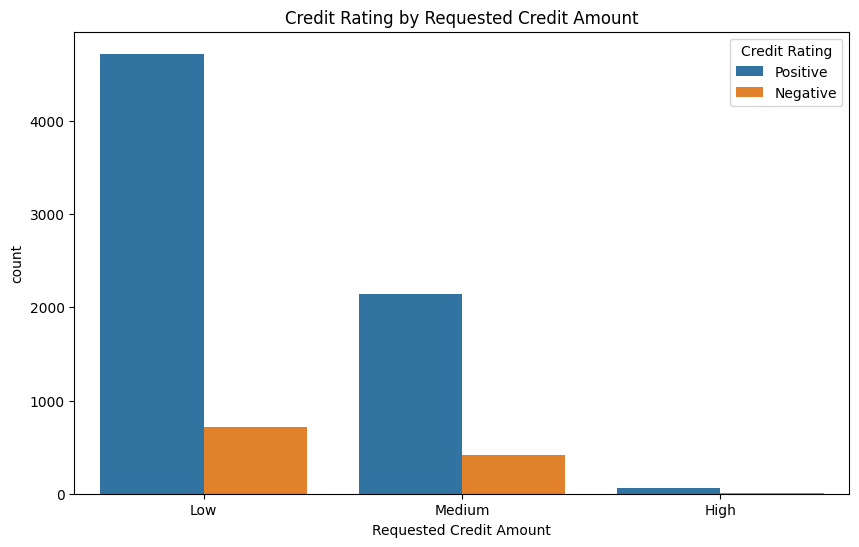

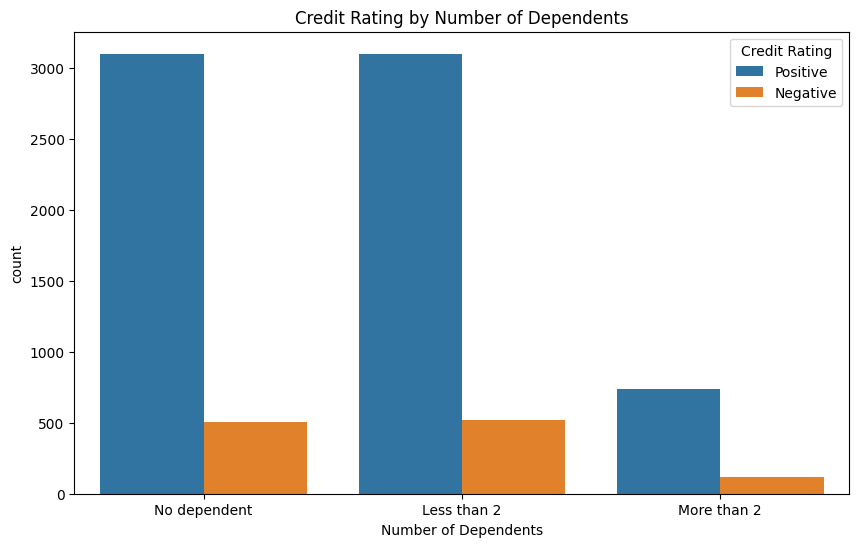

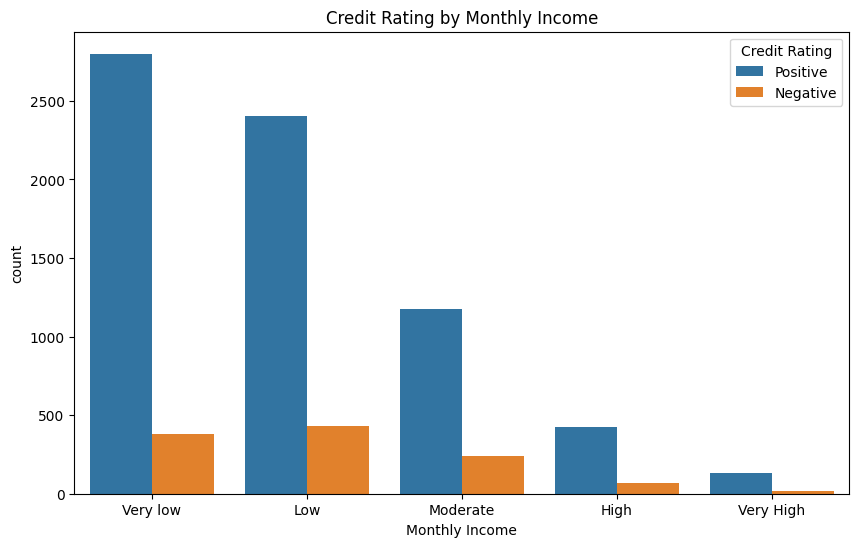

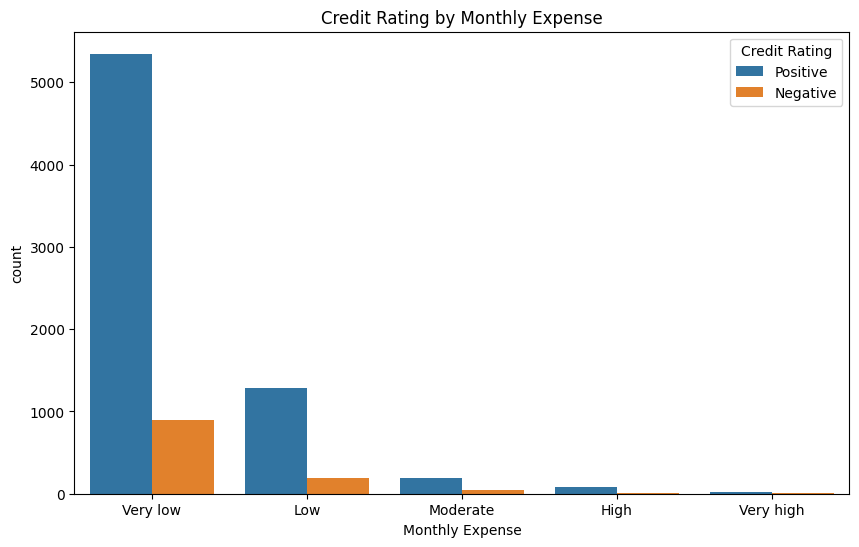

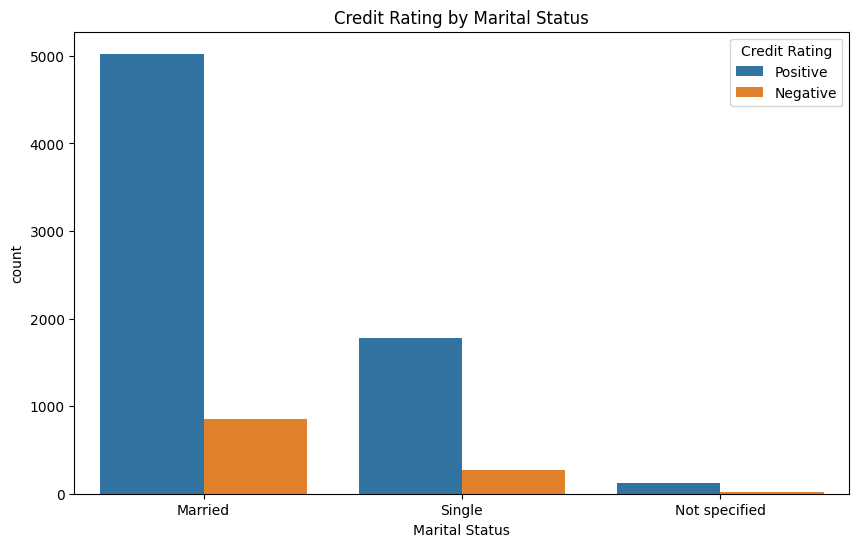

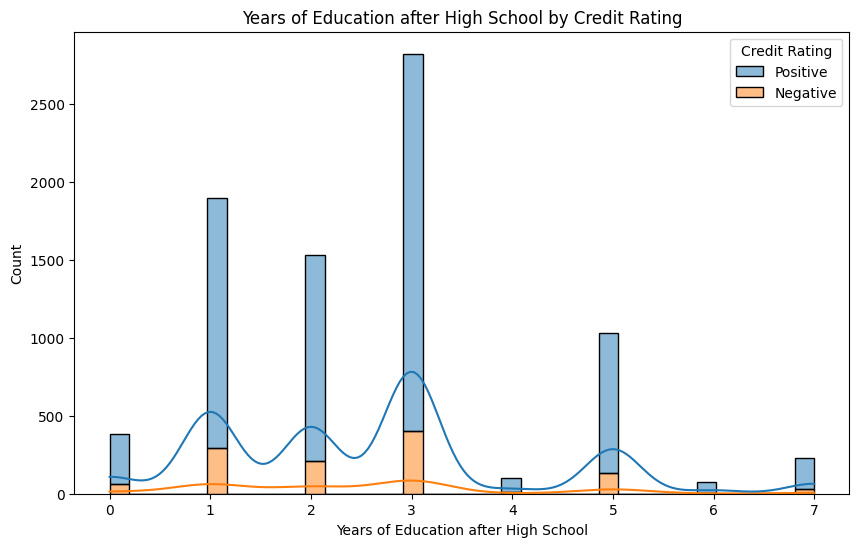

In [5]:
# Check the distribution of categorical variables to understand patterns in the data
print("Distribution of Requested Credit Amount:")
print(data['Requested Credit Amount'].value_counts(normalize=True))

print("\nDistribution of Number of Dependents:")
print(data['Number of Dependents'].value_counts(normalize=True))

print("\nDistribution of Monthly Income:")
print(data['Monthly Income'].value_counts(normalize=True))

print("\nDistribution of Monthly Expense:")
print(data['Monthly Expense'].value_counts(normalize=True))

print("\nDistribution of Marital Status:")
print(data['Marital Status'].value_counts(normalize=True))

# Examine relationships between features and the target variable
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of credit rating by Requested Credit Amount
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Requested Credit Amount', hue='Credit Rating')
plt.title('Credit Rating by Requested Credit Amount')
plt.show()

# Plot distribution of credit rating by Number of Dependents
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Number of Dependents', hue='Credit Rating')
plt.title('Credit Rating by Number of Dependents')
plt.show()

# Plot distribution of credit rating by Monthly Income
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Monthly Income', hue='Credit Rating')
plt.title('Credit Rating by Monthly Income')
plt.show()

# Plot distribution of credit rating by Monthly Expense
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Monthly Expense', hue='Credit Rating')
plt.title('Credit Rating by Monthly Expense')
plt.show()

# Plot distribution of credit rating by Marital Status
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Marital Status', hue='Credit Rating')
plt.title('Credit Rating by Marital Status')
plt.show()

# Examine distribution of Years of Education after High School by Credit Rating
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Years of Education after High School', hue='Credit Rating', multiple='stack', kde=True)
plt.title('Years of Education after High School by Credit Rating')
plt.show()



### Insights for Model Building and Feature Selection

1. **Requested Credit Amount**:
   - The majority of requests fall under the "Low" and "Medium" categories, with very few "High" requests.
   - "High" credit amount requests show a relatively higher proportion of "Negative" ratings, indicating that large credit amounts might be a risk factor.
   - **Model Insight**: Include "Requested Credit Amount" as a feature in the model, as it could serve as an indicator of credit risk. Consider encoding this variable in a way that highlights the relative risk of each level.

2. **Number of Dependents**:
   - The distribution is balanced between "No dependent" and "Less than 2" dependents, with fewer customers in the "More than 2" category.
   - There appears to be a slightly higher rate of "Negative" ratings among those with more dependents, potentially indicating financial strain.
   - **Model Insight**: "Number of Dependents" should be retained as a feature, as it may provide additional context for assessing financial stability and risk.

3. **Monthly Income and Monthly Expense**:
   - Most customers report "Very Low" or "Low" income, and a similar pattern exists for monthly expenses. Income and expense levels might be correlated but could provide unique information.
   - The relative distribution of "Positive" and "Negative" ratings across income levels suggests these features are relevant to credit risk.
   - **Model Insight**: Both "Monthly Income" and "Monthly Expense" should be included, as they provide insights into customers’ financial capacity and expenditure behavior. However, we may need to watch for multicollinearity between income and expenses.

4. **Marital Status**:
   - A significant portion of customers are "Married," and this group has a higher proportion of "Positive" ratings compared to "Single" or "Not specified."
   - **Model Insight**: Marital status may serve as a proxy for stability or financial responsibility. This feature could be valuable in the model to capture additional social context.

5. **Years of Education after High School**:
   - There are peaks at certain education levels (1, 2, and 3 years), with higher education not clearly correlating with better credit ratings.
   - **Model Insight**: Since education level alone does not predict creditworthiness, consider including it as a feature but with low priority. If the model performs well without it, this feature could be removed to simplify the model.

### Feature Selection Strategy

- **Primary Features**: Based on the EDA, the following features should be prioritized in the model: 
  - `Requested Credit Amount`
  - `Number of Dependents`
  - `Monthly Income`
  - `Monthly Expense`
  - `Marital Status`

- **Secondary Feature**:
  - `Years of Education after High School` – This feature may add some predictive value but could be omitted if it does not improve model performance significantly.



3. Data Preprocessing and Cross-Validation

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

# Separate features and target variable
X = data.drop(columns=['Credit Rating'])
y = data['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)  # Convert target to binary (1 for Positive, 0 for Negative)

# Define categorical and numerical features
categorical_features = ['Requested Credit Amount', 'Number of Dependents', 'Monthly Income', 'Monthly Expense', 'Marital Status']
numerical_features = ['Years of Education after High School']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the feature matrix
X_transformed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.5, random_state=42, stratify=y)

# Initialize a logistic regression model (for cross-validation)
model = LogisticRegression(max_iter=1000)

# Define the scoring metric as F1 score
scorer = make_scorer(f1_score)

# Perform cross-validation on the training data using F1 score
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

# Output the cross-validation F1 scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())
print("Standard Deviation of F1 Score:", cv_scores.std())



Cross-Validation F1 Scores: [0.9241012  0.9241012  0.92338441 0.92338441 0.92338441]
Mean F1 Score: 0.9236711255966948
Standard Deviation of F1 Score: 0.0003511529751880806


4. Hyperparameter Tuning and Modelling

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# Define the parameter grid for GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # Regularization parameter
    'solver': ['lbfgs', 'liblinear'],  # Solvers suitable for binary classification
    'class_weight': [None, 'balanced']  # To address class imbalance
}

# Set up GridSearch with cross-validation (using F1 score as the metric)
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Apply the best model to the test set
y_pred = best_model.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate and print recall, precision, and F1 score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRecall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


Best Hyperparameters: {'C': 0.01, 'class_weight': None, 'solver': 'lbfgs'}

Confusion Matrix:
[[   0  573]
 [   0 3468]]

Recall: 1.0
Precision: 0.858203414996288
F1 Score: 0.923691570115861


### Model Evaluation Results

1. **Best Hyperparameters**:
   - After performing GridSearch, the optimal hyperparameters for the logistic regression model were found to be:
     - **C**: 0.01 (indicating stronger regularization)
     - **class_weight**: None (suggesting that class weighting was not necessary for the best performance)
     - **solver**: lbfgs (an efficient solver for logistic regression with large datasets)

2. **Confusion Matrix**:
- This matrix shows that the model predicted **all instances as the positive class ("Positive")**.
- **True Negatives** (top-left cell): 0
- **False Positives** (top-right cell): 573
- **False Negatives** (bottom-left cell): 0
- **True Positives** (bottom-right cell): 3468
- The lack of true negatives and false negatives indicates that the model fails to identify the negative class ("Negative") altogether, predicting every instance as positive.

3. **Recall**: 1.00
- With no false negatives, recall reaches the maximum value of 1.00. However, this high recall is misleading because it’s a result of the model predicting only one class (positive).

4. **Precision**: 0.86
- Despite predicting only positives, the model achieves a precision of 0.86, indicating that 86% of the predicted positives are actually positive. However, this metric alone does not reflect the model’s inability to recognize the negative class.

5. **F1 Score**: 0.92
- The F1 score, a harmonic mean of precision and recall, is 0.92, which would typically indicate a strong model.
- However, since the model is biased towards predicting only the positive class, this F1 score is misleading in representing its actual performance across both classes.

### Analysis of the Results

The model’s **recall of 1.00** is unusual and concerning because it suggests that the model is simply predicting all instances as positive, which is confirmed by the confusion matrix. This issue is likely due to the **class imbalance** in the dataset, where positive cases dominate the data, leading the model to classify every instance as positive to minimize loss.


# Try the 15% Threshold Scenario

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
import numpy as np

# Get prediction probabilities on the training set using cross-validation
y_pred_prob_cv = cross_val_predict(best_model, X_train, y_train, cv=5, method="predict_proba")[:, 1]

# Calculate the threshold to approve only 15% of the applications
threshold_15 = np.percentile(y_pred_prob_cv, 85)  # Top 15% classified as positive

# Adjust predictions based on the 15% threshold
y_pred_15_cv = (y_pred_prob_cv >= threshold_15).astype(int)

# Calculate F1 score with 15% threshold
f1_cv = f1_score(y_train, y_pred_15_cv)

# Output the F1 score
print("Cross-Validation F1 Score with 15% Threshold:", f1_cv)


Cross-Validation F1 Score with 15% Threshold: 0.26461237466373194


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# Get prediction probabilities on the test set using the best model
y_pred_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate the threshold to approve only 15% of the applications
threshold_15 = np.percentile(y_pred_prob_test, 85)  # Top 15% will be classified as positive

# Adjust predictions based on the 15% threshold
y_pred_15 = (y_pred_prob_test >= threshold_15).astype(int)

# Calculate and print the confusion matrix for the 15% threshold model
conf_matrix_15 = confusion_matrix(y_test, y_pred_15)
print("\nConfusion Matrix with 15% Threshold:")
print(conf_matrix_15)

# Calculate and print recall, precision, and F1 score for the 15% threshold model
recall_15 = recall_score(y_test, y_pred_15)
precision_15 = precision_score(y_test, y_pred_15)
f1_15 = f1_score(y_test, y_pred_15)

print("\nRecall with 15% Threshold:", recall_15)
print("Precision with 15% Threshold:", precision_15)
print("F1 Score with 15% Threshold:", f1_15)



Confusion Matrix with 15% Threshold:
[[ 506   67]
 [2867  601]]

Recall with 15% Threshold: 0.17329873125720877
Precision with 15% Threshold: 0.8997005988023952
F1 Score with 15% Threshold: 0.29061895551257255


### Analysis of Model Performance with 15% Threshold

The model’s performance after applying the 15% threshold shows a significant shift in its behavior:

1. **Recall**: 0.1733
   - Recall has dropped considerably. This indicates that the model is now capturing only a small portion of actual positive cases, as it only labels the highest 15% of predicted probabilities as "Positive."
   - The low recall is a consequence of the threshold adjustment, which limits positive predictions to a smaller, more selective subset.

2. **Precision**: 0.8997
   - Precision is high at 0.8997, meaning that when the model predicts a positive case, it is correct nearly 90% of the time.
   - This high precision suggests that the model is now more confident in its positive predictions, focusing on a smaller set of highly likely positive cases and reducing false positives.

3. **F1 Score**: 0.2906
   - The F1 score has dropped to 0.2906. This lower score reflects the trade-off between precision and recall; as the recall decreased significantly, it impacted the harmonic mean, resulting in a lower F1 score.

### Comparison with Previous Model (Without Threshold Adjustment)

In comparison, the previous model (without threshold adjustment) achieved an F1 score of 0.9237, but this was due to predicting all cases as positive, resulting in:
- **High recall** (1.00) but no ability to identify negative cases.
- **Moderate precision** (0.8582), since some positive predictions were incorrect, but most were correct given the majority positive class distribution.

The **15% threshold model**, by contrast, represents a more practical approach:
- **Balanced classification**: It now correctly identifies both positive and negative cases, unlike the previous model, which ignored the negative class.
- **Increased precision**: By restricting positive predictions to the top 15% of probabilities, the model has improved its precision, making its positive predictions more reliable.
- **Realistic performance**: Although the recall and F1 score are lower, the model's behavior is more aligned with real-world scenarios where both classes need to be considered.

### Conclusion

The 15% threshold adjustment has transformed the model into a more balanced and practical tool by enabling it to recognize both positive and negative cases. While the F1 score and recall are lower, they now provide a more **realistic measure of model performance** and highlight its selectivity in positive predictions.
